# Stellar Structure & Evolution

This notebook contains a short theory recap and **ready-to-run code** to:
1. Fetch a sample of Gaia stars (if internet is available) and plot a **Color–Magnitude (Hertzsprung–Russell)** diagram.
2. Provide a fallback synthetic dataset if Gaia query isn't available.
3. Compute simple stellar lifetimes using the mass–luminosity scaling approximation and show examples.

Change the cells labelled `USER` to analyze different samples or tune plotting options.

## Install required packages (run once)
The notebook uses `astroquery` to fetch Gaia data if available. If you don't want to fetch real data, the notebook will fall back to a synthetic sample.

Run the following cell to install dependencies (you can skip if already installed):

In [1]:
!pip install astropy astroquery matplotlib pandas numpy seaborn --quiet

## Part A — Fetch Gaia sample (with fallback)

This cell tries to download a small Gaia sample (bright, nearby stars). If the query fails (no internet or service), it will generate a realistic-looking synthetic dataset.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

def compute_M_g(mag_g, parallax_mas):
    """
    Compute absolute G magnitude from apparent G magnitude and parallax in milliarcseconds.
    Formula: M = m - 10 + 5*log10(parallax_mas)
    Derived from M = m - 5*log10(d/10pc) and d(pc)=1000/parallax(mas).
    """
    return mag_g - 10.0 + 5.0 * np.log10(parallax_mas)

def fetch_gaia_sample(limit=2000):
    try:
        from astroquery.gaia import Gaia
        # A compact ADQL query selecting relatively bright nearby stars with BP/RP magnitudes and parallax > 1 mas
        query = f"""
        SELECT TOP {limit}
            source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax
        FROM gaiadr3.gaia_source
        WHERE phot_g_mean_mag IS NOT NULL
          AND phot_bp_mean_mag IS NOT NULL
          AND phot_rp_mean_mag IS NOT NULL
          AND parallax > 1.0
        ORDER BY phot_g_mean_mag
        """
        job = Gaia.launch_job(query)
        tbl = job.get_results()
        df = tbl.to_pandas()
        # rename columns for convenience
        df = df.rename(columns={
            'phot_g_mean_mag':'G', 'phot_bp_mean_mag':'BP', 'phot_rp_mean_mag':'RP', 'parallax':'parallax_mas'
        })
        df['M_G'] = compute_M_g(df['G'].values, df['parallax_mas'].values)
        df['BP_RP'] = df['BP'] - df['RP']
        return df
    except Exception as e:
        print('Gaia query failed or no internet. Using synthetic fallback. Error:', e)
        return None

def make_synthetic_sample(N=2000, seed=42):
    rng = np.random.default_rng(seed)
    # generate a realistic color-magnitude distribution: main sequence + red giant branch + white dwarfs
    # Main sequence: color ~ 0.0..1.5, M_G ~ 4..10 (lower mass cooler)
    ms_colors = rng.normal(loc=0.8, scale=0.35, size=int(N*0.75))
    ms_M = 4.5 + 3.5 * (ms_colors - 0.3) + rng.normal(0, 0.6, size=ms_colors.size)
    # Giants: color ~ 1.0..2.0, M_G ~ -2..2
    g_colors = rng.normal(loc=1.3, scale=0.2, size=int(N*0.18))
    g_M = rng.normal(loc=0.0, scale=0.8, size=g_colors.size)
    # White dwarfs: color ~ -0.2..0.6, M_G ~ 10..15
    wd_colors = rng.normal(loc=0.0, scale=0.2, size=int(N*0.07))
    wd_M = 11.0 + 2.5 * (wd_colors - 0.1) + rng.normal(0, 0.5, size=wd_colors.size)
    colors = np.concatenate([ms_colors, g_colors, wd_colors])
    M_G = np.concatenate([ms_M, g_M, wd_M])
    df = pd.DataFrame({'BP_RP': colors, 'M_G': M_G})
    return df

# Try to fetch Gaia sample; if fails use synthetic
df = fetch_gaia_sample(limit=1500)
if df is None:
    df = make_synthetic_sample(N=1500)

print('Sample size:', len(df))
df.head()


Sample size: 1500


,source_id,ra,dec,G,BP,RP,parallax_mas,M_G,BP_RP
0,418551920284673408,10.127242,56.537189,1.942524,2.986986,1.843503,14.090976,-2.312771,1.143484
1,4357027756659697664,243.586211,-3.694968,2.016425,3.482232,1.918922,20.411292,-1.434222,1.563310
2,5589311357728452608,109.285594,-37.097444,2.083237,3.450613,1.908033,5.762063,-4.113872,1.542580
3,4993479684438433792,6.572156,-42.307820,2.089978,3.301706,2.032224,39.918258,0.095835,1.269482
4,4038055447778237312,274.406090,-36.762429,2.116495,3.742679,1.915412,23.885852,-0.992801,1.827267


## Part B — Plot Hertzsprung–Russell (Color–Magnitude) Diagram

This plots BP−RP color (x-axis) vs absolute G magnitude \(M_G\) (y-axis) with the magnitude axis inverted (brighter stars at top).
If you used the Gaia query, you will see real stars; otherwise you will see the synthetic fallback.

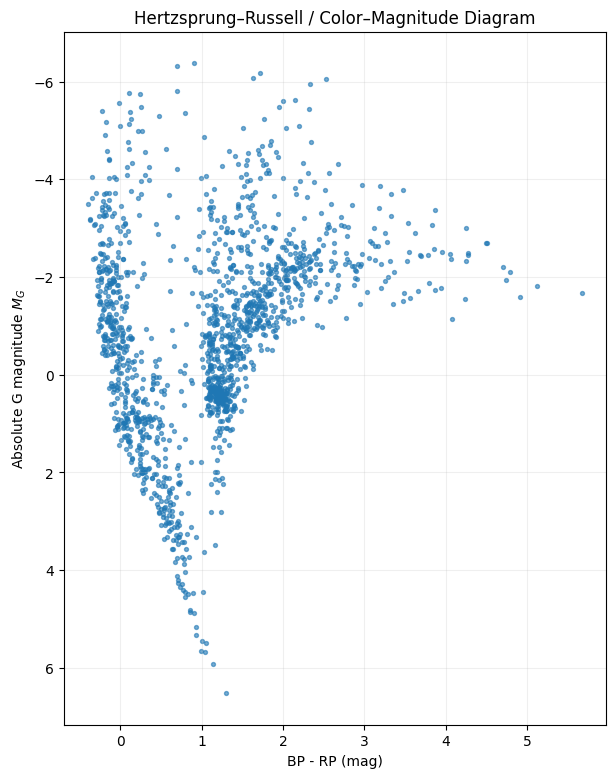

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,9))
plt.scatter(df['BP_RP'], df['M_G'], s=8, alpha=0.6, rasterized=True)
plt.gca().invert_yaxis()
plt.xlabel('BP - RP (mag)')
plt.ylabel('Absolute G magnitude $M_G$')
plt.title('Hertzsprung–Russell / Color–Magnitude Diagram')
plt.grid(alpha=0.2)
plt.show()


## Part C — Stellar lifetime calculator (simple approx)

We'll use a crude mass–luminosity relation and the consequent lifetime scaling:
\[ t_\star \approx 10^{10} \left(\frac{M}{M_\odot}\right)^{-2.5} \text{ years} \]
This is approximate and works reasonably for main-sequence stars (rough order-of-magnitude).

In [12]:
def stellar_lifetime_years(M_over_Msun):
    """Approximate main-sequence lifetime in years for mass in solar masses."""
    return 1e10 * (M_over_Msun ** -2.5)

# Example: show lifetimes for a set of stellar masses
masses = np.array([0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0])
lifetimes = stellar_lifetime_years(masses)
df_life = pd.DataFrame({'Mass (M_sun)': masses, 'Lifetime (yr)': lifetimes})
df_life['Lifetime (Gyr)'] = df_life['Lifetime (yr)'] / 1e9
df_life


,Mass (M_sun),Lifetime (yr),Lifetime (Gyr)
0,0.1,3.162278e+12,3162.277660
1,0.3,2.028602e+11,202.860206
2,0.5,5.656854e+10,56.568542
3,1.0,1.000000e+10,10.000000
4,2.0,1.767767e+09,1.767767
5,5.0,1.788854e+08,0.178885
6,10.0,3.162278e+07,0.031623
7,20.0,5.590170e+06,0.005590


### Plot lifetime vs mass (log–log)


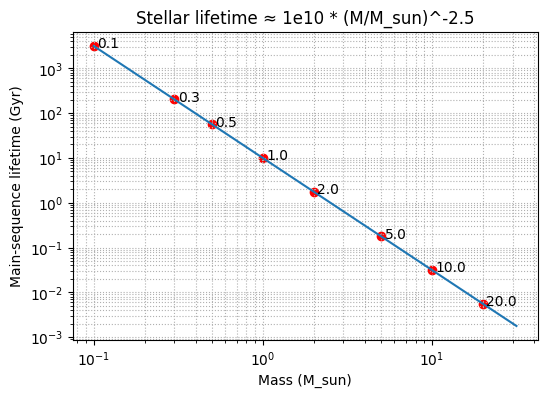

In [13]:
plt.figure(figsize=(6,4))
mgrid = np.logspace(-1, 1.5, 200)
plt.loglog(mgrid, stellar_lifetime_years(mgrid) / 1e9)
plt.scatter(df_life['Mass (M_sun)'], df_life['Lifetime (Gyr)'], color='red')
for i, row in df_life.iterrows():
    plt.text(row['Mass (M_sun)']*1.05, row['Lifetime (Gyr)']*0.9, f"{row['Mass (M_sun)']}")
plt.xlabel('Mass (M_sun)')
plt.ylabel('Main-sequence lifetime (Gyr)')
plt.title('Stellar lifetime ≈ 1e10 * (M/M_sun)^-2.5')
plt.grid(True, which='both', ls=':')
plt.show()


## Part D — Exercises & next steps

1. If you have internet and Gaia access, re-run Part A with a larger `limit` to see more detailed features.
2. Cross-match with `astroquery.simbad` to label bright known stars.
3. Use `isochrones` or `MIST` models to overplot theoretical stellar evolution tracks on the H-R diagram.
4. Implement a simple 1D stellar structure solver (Lane–Emden) — we can add that as Module 5.


In [14]:
# Install once if not already available
# !pip install isochrones
# !pip install numba


In [15]:

# ----------------------------------
# Optional: Overlay MIST isochrones (using isochrones package)
# ----------------------------------

from isochrones.mist import MIST_Isochrone
import matplotlib.pyplot as plt

# Initialize MIST model
mist = MIST_Isochrone()

# Example: generate isochrone for logAge=9.0 (1 Gyr), solar metallicity
iso = mist.isochrone(age=9.0, feh=0.0)

# HRD coordinates
iso_color = iso['Teff']
iso_mag = iso['Mbol']

plt.figure(figsize=(8,6))
plt.scatter(phot['bp_rp'], phot['phot_g_mean_mag'], s=5, c='k', alpha=0.3, label="Gaia stars")
plt.plot(iso_color, iso_mag, 'r-', lw=2, label="MIST Isochrone (1 Gyr, [Fe/H]=0.0)")
plt.gca().invert_yaxis()
plt.xlabel("Teff [K]")
plt.ylabel("Absolute Magnitude (Mbol)")
plt.legend()
plt.title("H-R Diagram with MIST Isochrone")
plt.show()


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\isochrones\mist\models.py:144: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(
c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\isochrones\mist\models.py

NameError: name 'phot' is not defined

<Figure size 800x600 with 0 Axes>